In [483]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Hyundai-FLANT5.csv', low_memory=False)
df['Components'] = df['COMPSYS_1'].str.split(',').str[0]

def other_comp(system):
   if system == 'electrical system' or system == 'seat belts':
        return 'other component'
   else:
        return system

df['Emergent Components'] = df['Components'].apply(other_comp)

filtered_df = df[['LDATE','CDESCR', 'Components', 'LABELS_1', 'LABELS_2', 'LABELS_3', 'Emergent Components']].copy()

filtered_df['LDATE_1M'] = pd.to_datetime(filtered_df['LDATE'], format='mixed').dt.to_period('M')
filtered_df['LDATE_1M'] = pd.to_datetime(filtered_df['LDATE_1M'].astype(str))

filtered_df['LDATE_1Y'] = pd.to_datetime(filtered_df['LDATE'], format='mixed').dt.to_period('M')
filtered_df['LDATE_1Y'] = pd.to_datetime(filtered_df['LDATE_1Y'].astype(str))

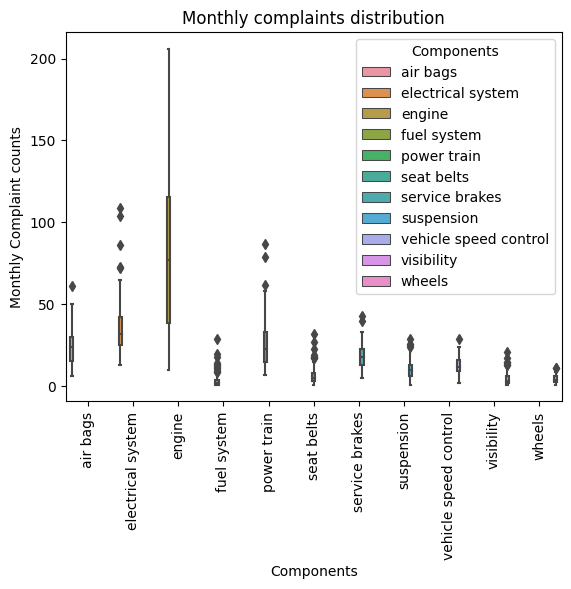

In [537]:
sns.boxplot(data=filtered_df.groupby(['Components', 'LDATE_1M']).count()[['CDESCR']].reset_index(),x='Components', y='CDESCR', hue='Components')
_=plt.xticks(rotation=90)
plt.ylabel('Monthly Complaint counts')
plt.title('Monthly complaints distribution')
plt.savefig('class_dist.svg', format='svg')

In [485]:
important_parts = ['air bags', 'fuel system', 'power train', 'suspension', 'vehicle speed control', 'visibility', 'wheels', 'engine', 'service brakes', 'electrical system', 'seat belts']

def gen_true_pos_graph(filtered_df, system):
    new_df = filtered_df[filtered_df['Components']==system].copy()
    compsys_1 = new_df.groupby(by=['LDATE_1M', 'Components'])[['CDESCR']].count()
    label_1 = new_df[new_df['LABELS_1']==system].groupby(by=['LDATE_1M', 'LABELS_1'])[['CDESCR']].count()
    label_2 = new_df[new_df['LABELS_2']==system].groupby(by=['LDATE_1M', 'LABELS_2'])[['CDESCR']].count()
    if system == 'electrical system' or system == 'seat belts':
        label_3 = new_df[new_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()
    else:
        label_3 = new_df[new_df['LABELS_3']==system].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()
    
    all_label_1 = filtered_df[filtered_df['LABELS_1']==system].groupby(by=['LDATE_1M', 'LABELS_1'])[['CDESCR']].count()
    all_label_2 = filtered_df[filtered_df['LABELS_2']==system].groupby(by=['LDATE_1M', 'LABELS_2'])[['CDESCR']].count()
    if system == 'electrical system' or system == 'seat belts':
        all_label_3 = filtered_df[filtered_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()
    else:
        all_label_3 = filtered_df[filtered_df['LABELS_3']==system].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()

    f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    f.add_subplot(111, frameon=False)

    sns.lineplot(compsys_1, x='LDATE_1M', y='CDESCR', errorbar=None , ax=ax1, label='actual').set(xlabel=None, ylabel=None)
    sns.lineplot(label_1, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax1, label='prompt_no_parts').set(xlabel=None, ylabel=None)
    sns.lineplot(label_2, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax1, label='prompt_specific_parts').set(xlabel=None, ylabel=None)
    if system != 'electrical system' and system != 'seat belts':
        sns.lineplot(label_3, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax1, label='prompt_emergent_parts').set(xlabel=None, ylabel=None)
    
    ax1.set_title('TP')
    
    sns.lineplot(compsys_1, x='LDATE_1M', y='CDESCR', errorbar=None , ax=ax2, label='actual').set(xlabel=None, ylabel=None)
    sns.lineplot(all_label_1, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax2, label='prompt_no_parts').set(xlabel=None, ylabel=None)
    sns.lineplot(all_label_2, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax2, label='prompt_specific_parts').set(xlabel=None, ylabel=None)
    if system != 'electrical system' and system != 'seat belts':
        sns.lineplot(all_label_3, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax2, label='prompt_emergent_parts').set(xlabel=None, ylabel=None)
    
    ax2.set_title('TP+FP')


    plt.suptitle(f'2014-2023 Hyundai {system} complaints')
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Years')
    plt.ylabel('Monthly Complaint counts')
    plt.tight_layout()
    plt.savefig(f'{system}.svg', format='svg')



In [486]:
def gen_emergent_pos_graph(filtered_df):
    new_df = filtered_df[filtered_df['Emergent Components']=='other component'].copy()
    compsys_1 = new_df.groupby(by=['LDATE_1M', 'Emergent Components'])[['CDESCR']].count()
    label_3 = new_df[new_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()

    all_label_3 = filtered_df[filtered_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()

    f, (ax1, ax2) = plt.subplots(2,1, sharex=True)

    sns.lineplot(compsys_1, x='LDATE_1M', y='CDESCR', errorbar=None , ax=ax1, label='actual', color='blue').set(xlabel=None, ylabel=None)
    sns.lineplot(label_3, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax1, label='prompt_emergent_parts', color='red').set(xlabel=None, ylabel=None)
    
    ax1.set_title('TP')
    
    sns.lineplot(compsys_1, x='LDATE_1M', y='CDESCR', errorbar=None , ax=ax2, label='actual', color='blue').set(xlabel=None, ylabel=None)
    sns.lineplot(all_label_3, x='LDATE_1M', y='CDESCR',errorbar=None, ax=ax2, label='prompt_emergent_parts', color='red').set(xlabel=None, ylabel=None)
    
    ax2.set_title('TP+FP')

    plt.suptitle(f'2014-2023 Hyundai \'other component\' complaints')
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Years')
    plt.ylabel('Monthly Complaint counts')
    plt.tight_layout()
    plt.savefig(f'ec_othercomponent.svg', format='svg')


In [487]:
from sklearn.metrics import f1_score

def gen_f1_score(filtered_df, system):
    if system == 'electrical system' or system == 'seat belts':
        f, (ax1,ax2) = plt.subplots(2,1, sharex=True)
    else:
        f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
    f.add_subplot(111, frameon=False)
    def get_f1_score_l1(df):
        return f1_score(df['Components'], df['LABELS_1'], labels=[system], average='micro', zero_division=0)

    def get_f1_score_l2(df):
        return f1_score(df['Components'], df['LABELS_2'], labels=[system], average='micro', zero_division=0)

    def get_f1_score_l3(df):
        return f1_score(df['Emergent Components'], df['LABELS_3'], labels=[system], average='micro', zero_division=0)

    f1_score_df = filtered_df.groupby('LDATE_1M').apply(get_f1_score_l1).reset_index()
    f1_score_df['LABELS_1'] = f1_score_df[0]
    f1_score_df['LABELS_2'] = filtered_df.groupby('LDATE_1M').apply(get_f1_score_l2).reset_index()[0]
    if system != 'electrical system' and system != 'seat belts':
        f1_score_df['LABELS_3'] = filtered_df.groupby('LDATE_1M').apply(get_f1_score_l3).reset_index()[0]
    f1_score_df['Year'] = f1_score_df['LDATE_1M'].dt.year

    sns.pointplot(f1_score_df, x='Year', y='LABELS_1', ax=ax1, label='prompt_no_parts', color='orange', scale=0.5).set(xlabel=None, ylabel=None)
    sns.pointplot(f1_score_df, x='Year', y='LABELS_2', ax=ax2, label='prompt_specific_parts', color='green', scale=0.5).set(xlabel=None, ylabel=None)
    if system != 'electrical system' and system != 'seat belts':
        sns.pointplot(f1_score_df, x='Year', y='LABELS_3', ax=ax3, label='prompt_emergent_parts', color='red', scale=0.5).set(xlabel=None, ylabel=None)

    plt.suptitle(f'Yearly F1 scores ({system})')
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Years')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.savefig(f'f1_{system}.svg', format='svg')

In [488]:
def gen_f1_score_ec(filtered_df):
    f, ax = plt.subplots(sharex=True)
    f.add_subplot(111, frameon=False)

    def get_f1_score_l3(df):
        return f1_score(df['Emergent Components'], df['LABELS_3'], labels=['other component'], average='micro', zero_division=0)

    f1_score_df = filtered_df.groupby('LDATE_1M').apply(get_f1_score_l3).reset_index()
    f1_score_df['LABELS_3'] = f1_score_df[0]
    f1_score_df['Year'] = f1_score_df['LDATE_1M'].dt.year

    sns.pointplot(f1_score_df, x='Year', y='LABELS_3', ax=ax, label='prompt_emergent_parts', color='red', scale=0.5).set(xlabel=None, ylabel=None)

    plt.suptitle(f'Yearly F1 scores (other component)')
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Years')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.savefig(f'ec_f1.svg', format='svg')

C:\Users\prith\AppData\Local\Temp\ipykernel_22796\3033686562.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2) = plt.subplots(2,1, sharex=True)


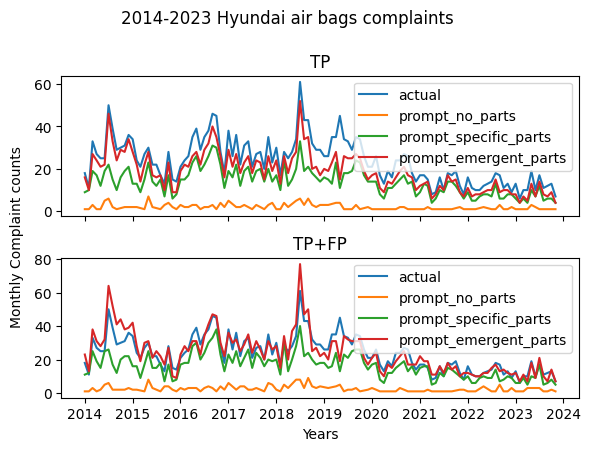

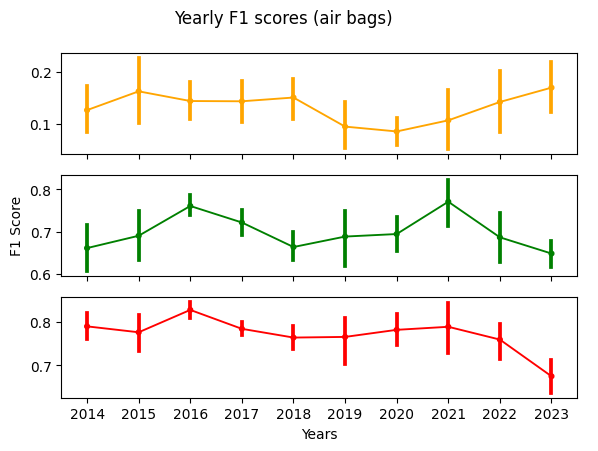

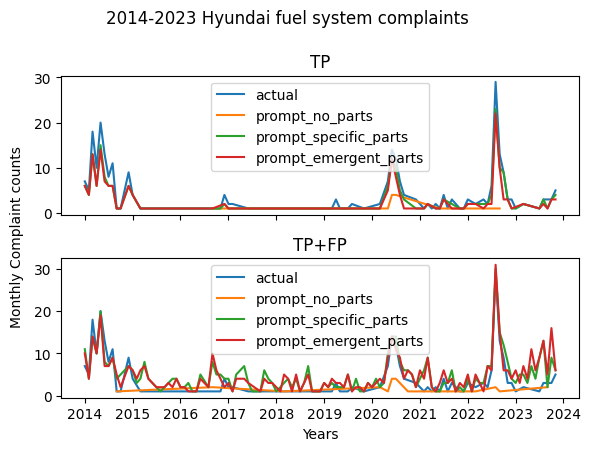

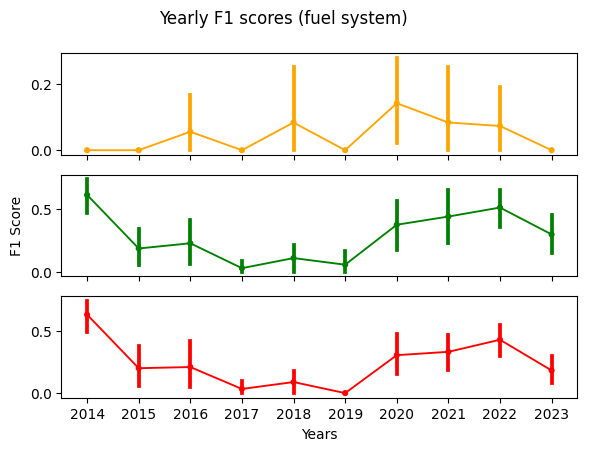

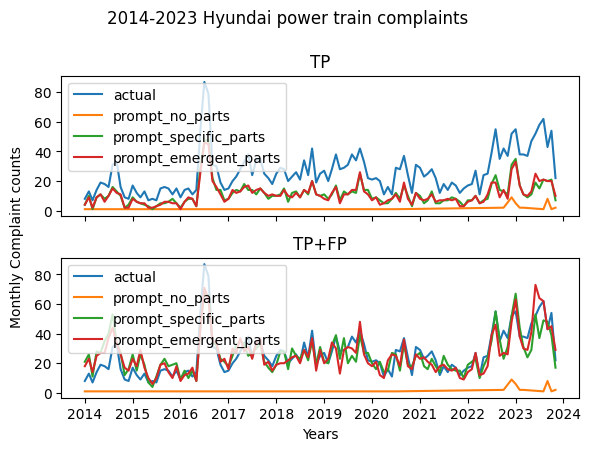

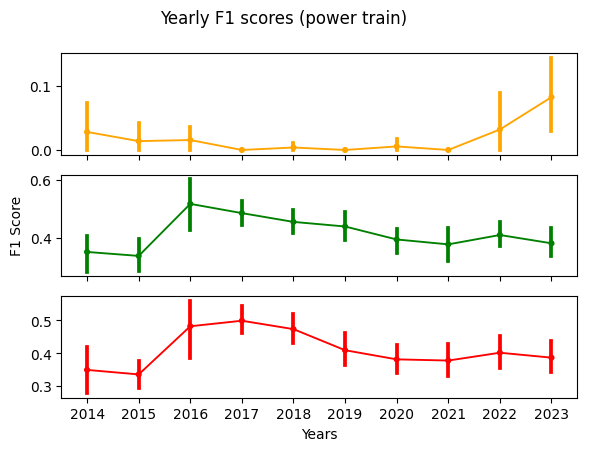

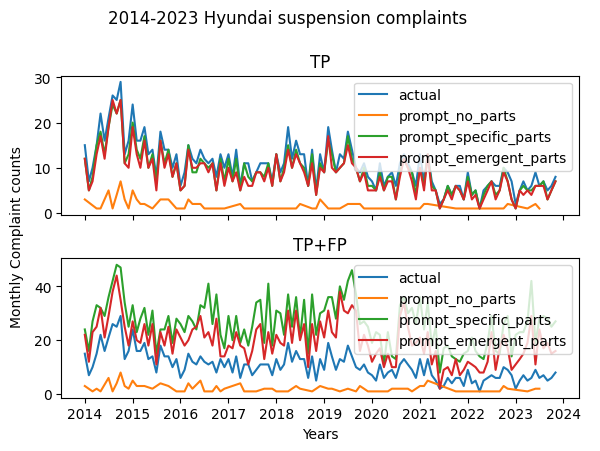

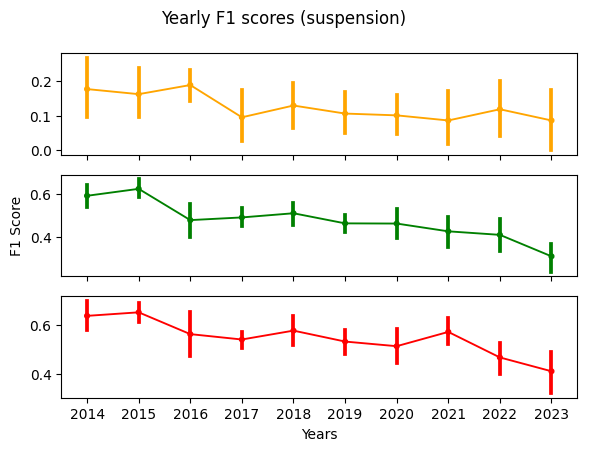

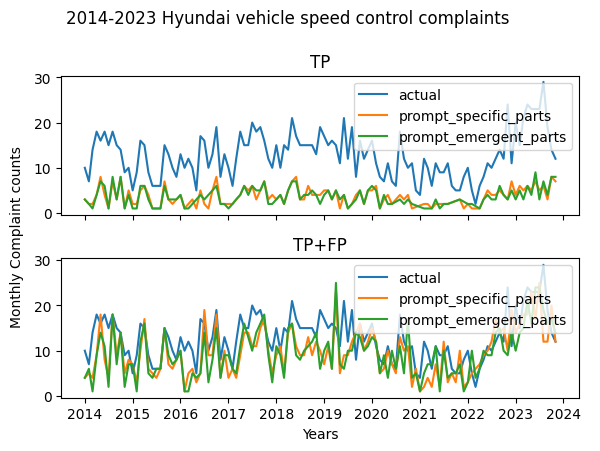

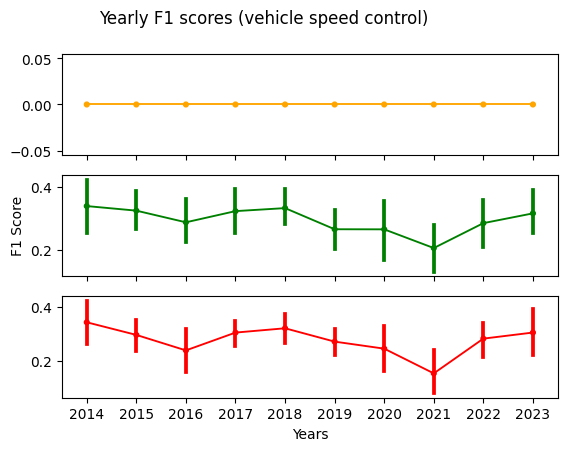

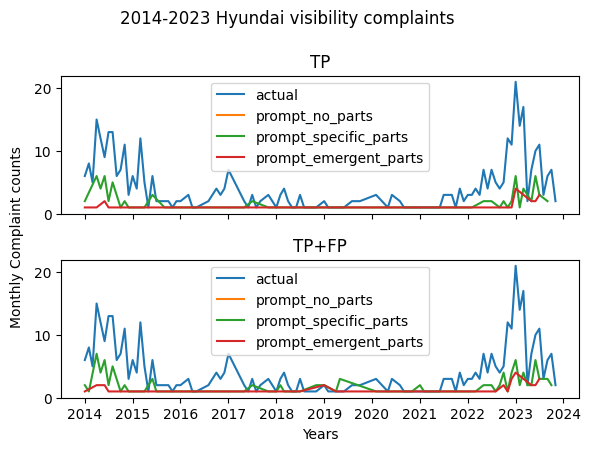

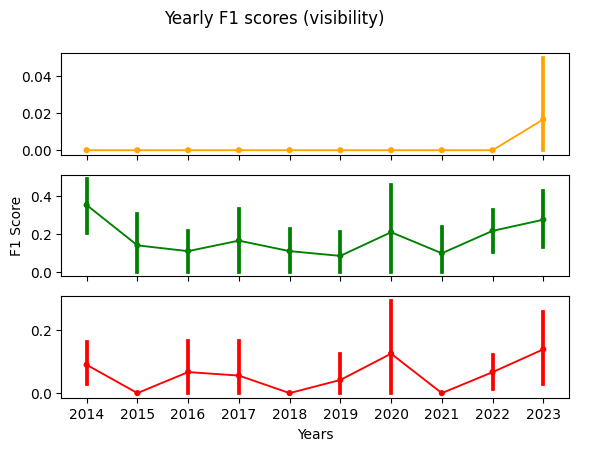

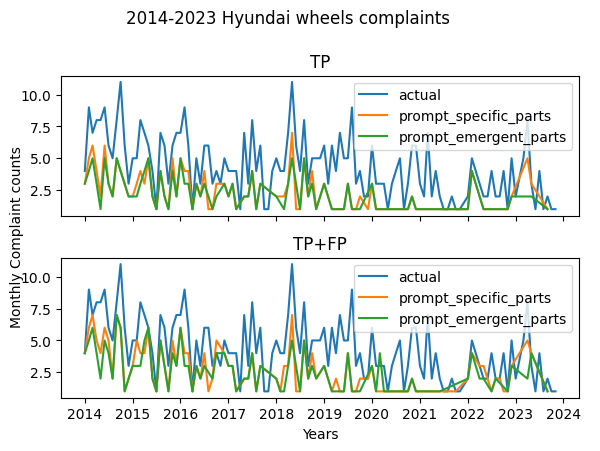

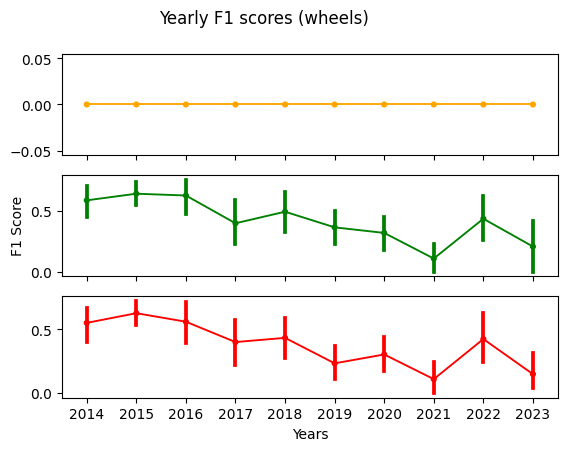

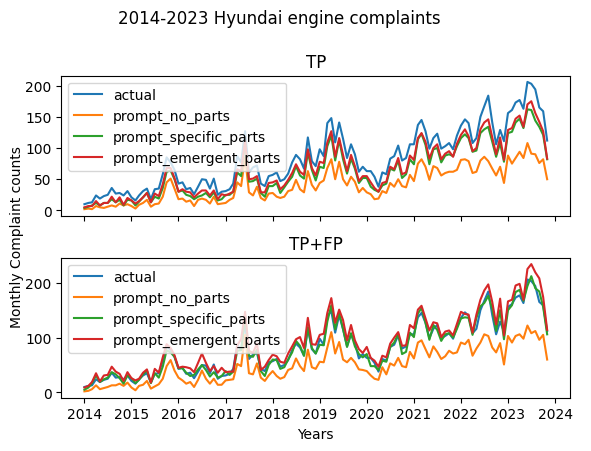

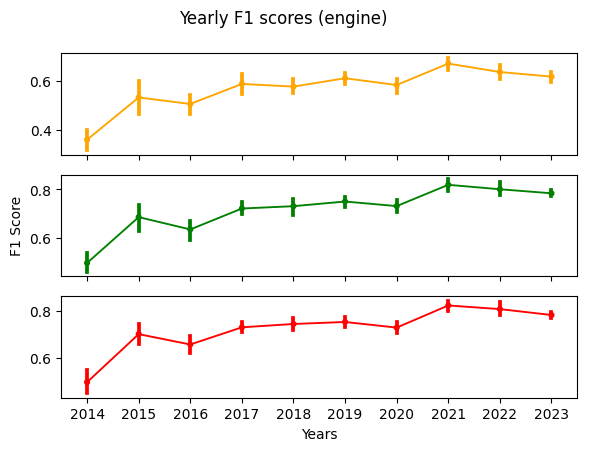

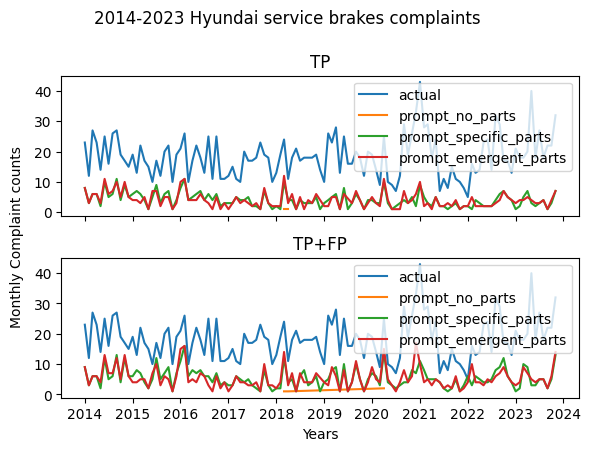

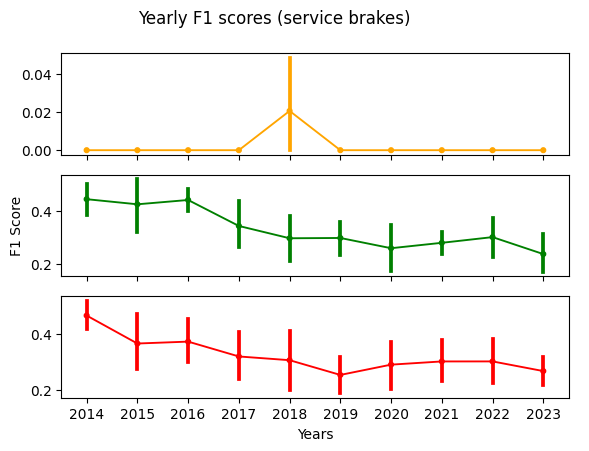

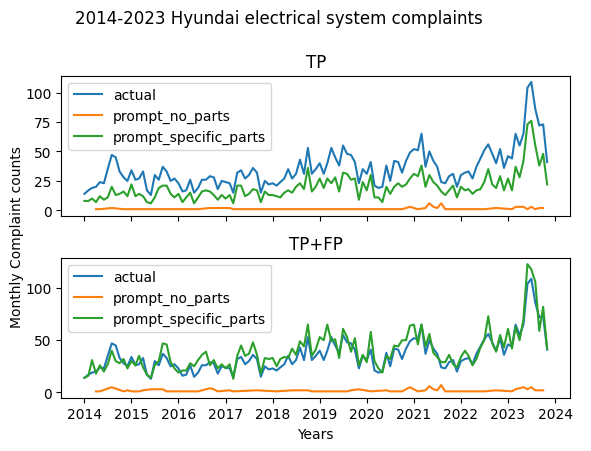

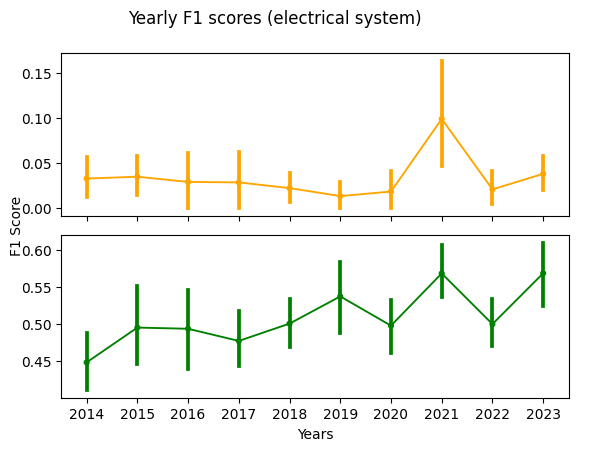

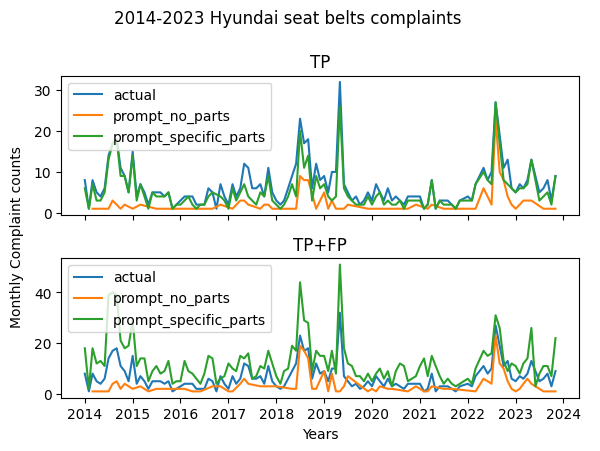

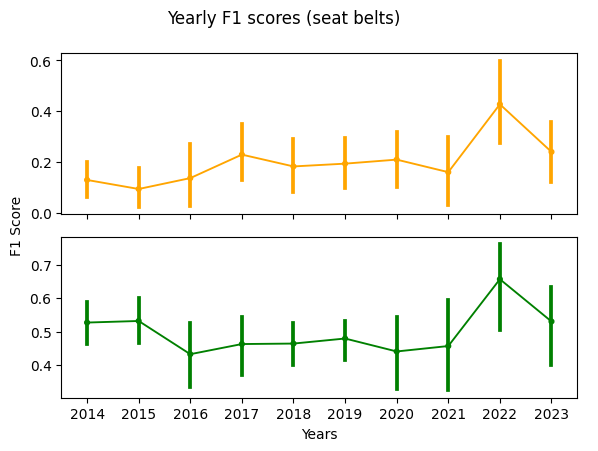

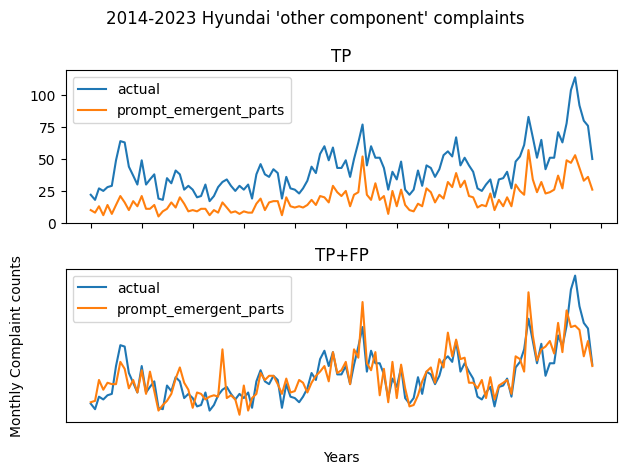

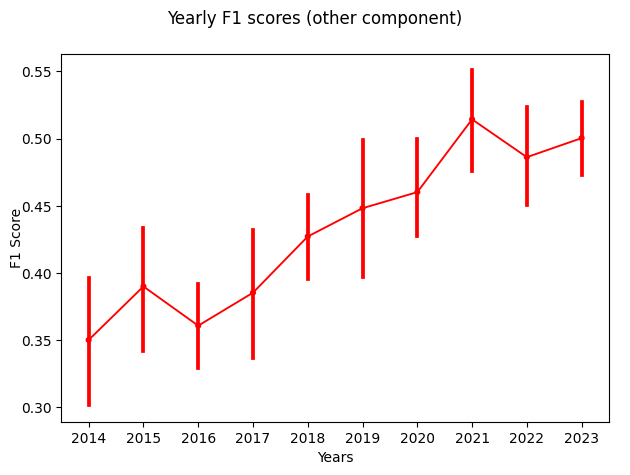

In [489]:
for i in range(len(important_parts)):
    gen_true_pos_graph(filtered_df, important_parts[i])
    gen_f1_score(filtered_df, important_parts[i])

gen_emergent_pos_graph(filtered_df)
gen_f1_score_ec(filtered_df)


In [532]:
# from scipy.stats import zscore
# import numpy as np

# def zs(df):
#     df = df.fillna(0)
#     return np.max(np.abs(zscore(df['CDESCR'])))

# def gen_std_graph(filtered_df, system):
#     new_df = filtered_df[filtered_df['Components']==system].copy()
#     compsys_1 = new_df.groupby(by=['LDATE_1M', 'Components'])[['CDESCR']].count()
    
#     diff_label_1 = filtered_df[filtered_df['LABELS_1']==system].groupby(by=['LDATE_1M', 'LABELS_1'])[['CDESCR']].count()-compsys_1
#     diff_label_2 = filtered_df[filtered_df['LABELS_2']==system].groupby(by=['LDATE_1M', 'LABELS_2'])[['CDESCR']].count()-compsys_1
#     # if system == 'electrical system' or system == 'seat belts':
#     #     diff_label_3 = filtered_df[filtered_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()-compsys_1
#     # else:
#     #     diff_label_3 = filtered_df[filtered_df['LABELS_3']==system].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()-compsys_1

#     diff_label_1 = diff_label_1.reset_index()
#     diff_label_2 = diff_label_2.reset_index()
#     # diff_label_3 = diff_label_3.reset_index()
    
#     diff_label_1['Years'] = diff_label_1['LDATE_1M'].dt.year
#     diff_label_2['Years'] = diff_label_2['LDATE_1M'].dt.year
#     # diff_label_3['Years'] = diff_label_3['LDATE_1M'].dt.year
    
#     std_1 = diff_label_1.groupby('Years')[['CDESCR']].apply(zs).reset_index().fillna(0)
#     std_2 = diff_label_2.groupby('Years')[['CDESCR']].apply(zs).reset_index().fillna(0)
#     # std_3 = diff_label_3.groupby('Years')[['CDESCR']].apply(zs).reset_index()
#     display(std_1)

#     std_1['max_std'] = std_1[0]
#     std_2['max_std'] = std_2[0]
#     # std_3['max_std'] = std_3[0]
#     f, ax = plt.subplots()
#     f.add_subplot(111, frameon=False)
#     display(std_1)
    
#     sns.lineplot(std_1, x='Years', y='max_std',errorbar=None, ax=ax, label='prompt_no_parts', color='orange').set(xlabel=None, ylabel=None)
#     sns.lineplot(std_2, x='Years', y='max_std',errorbar=None, ax=ax, label='prompt_specific_parts', color='green').set(xlabel=None, ylabel=None)
#     # sns.lineplot(std_3, x='Years', y='max_std',errorbar=None, ax=ax, label='prompt_emergent_parts', color='red').set(xlabel=None, ylabel=None)

#     plt.suptitle(f'Maximum differenced standard deviation for {system} timeseries')
#     plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#     plt.xlabel('Years')
#     plt.ylabel('Standard deviation')
#     plt.tight_layout()
#     plt.savefig(f'std_{system}.svg', format='svg')

#     new_df = filtered_df[filtered_df['Components']==system].copy()
#     compsys_1 = new_df.groupby(by=['LDATE_1M', 'Components'])[['CDESCR']].count()
    
#     diff_label_1 = filtered_df[filtered_df['LABELS_1']==system].groupby(by=['LDATE_1M', 'LABELS_1'])[['CDESCR']].count()-compsys_1
#     diff_label_2 = filtered_df[filtered_df['LABELS_2']==system].groupby(by=['LDATE_1M', 'LABELS_2'])[['CDESCR']].count()-compsys_1
#     if system == 'electrical system' or system == 'seat belts':
#         diff_label_3 = filtered_df[filtered_df['LABELS_3']=='other component'].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()-compsys_1
#     else:
#         diff_label_3 = filtered_df[filtered_df['LABELS_3']==system].groupby(by=['LDATE_1M', 'LABELS_3'])[['CDESCR']].count()-compsys_1

#     diff_label_1 = diff_label_1.reset_index()
#     diff_label_2 = diff_label_2.reset_index()
#     diff_label_3 = diff_label_3.reset_index()
    
#     diff_label_1['Years'] = diff_label_1['LDATE_1M'].dt.year
#     diff_label_2['Years'] = diff_label_2['LDATE_1M'].dt.year
#     diff_label_3['Years'] = diff_label_3['LDATE_1M'].dt.year
    
#     std_1 = diff_label_1.groupby('Years')[['CDESCR']].apply(zs).reset_index()
#     std_2 = diff_label_2.groupby('Years')[['CDESCR']].apply(zs).reset_index()
#     std_3 = diff_label_3.groupby('Years')[['CDESCR']].apply(zs).reset_index()

#     std_1['max_std'] = std_1[0]
#     std_2['max_std'] = std_2[0]
#     std_3['max_std'] = std_3[0]
#     f, ax1 = plt.subplots()
#     f.add_subplot(111, frameon=False)
    
#     sns.lineplot(std_1, x='Years', y='max_std',errorbar=None, ax=ax1, label='prompt_no_parts', color='orange').set(xlabel=None, ylabel=None)
#     sns.lineplot(std_2, x='Years', y='max_std',errorbar=None, ax=ax1, label='prompt_specific_parts', color='green').set(xlabel=None, ylabel=None)
#     if system != 'electrical system' and system != 'seat belts':
#         sns.lineplot(std_3, x='Years', y='max_std',errorbar=None, ax=ax1, label='prompt_emergent_parts', color='red').set(xlabel=None, ylabel=None)

#     plt.suptitle(f'Maximum differenced standard deviation for {system} timeseries')
#     plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#     plt.xlabel('Years')
#     plt.ylabel('Standard deviation')
#     plt.tight_layout()
#     plt.savefig(f'std_{system}.svg', format='svg')
# # for i in range(len(important_parts)):
# #     print(important_parts[i])
# #     gen_std_graph(filtered_df, important_parts[i])
# gen_std_graph(filtered_df, 'vehicle speed control')

In [534]:
from sklearn.metrics import accuracy_score

accuracy_score(filtered_df['Components'], filtered_df['LABELS_1'])

0.20255467676655156

In [535]:
accuracy_score(filtered_df['Components'], filtered_df['LABELS_2'])

0.5895065166536705

In [536]:
accuracy_score(filtered_df['Emergent Components'], filtered_df['LABELS_3'])

0.5944450633099402